# Imports

In [11]:
#For importing data and parsing data
from operator import itemgetter
import pprint


#Converting parsed data into raw parsed data output to csv
import csv
from itertools import islice, izip


#For analyzing raw parsed data
import collections, re

    #had to uninstall python-dateutil and use old version dateutil 2.2 to avoid error
    #sudo pip uninstall python-dateutil
    #sudo pip install python-dateutil==2.2
import matplotlib.pyplot as plt
import numpy as np 
import matplotlib.gridspec as gridspec


#had to install this using pip on local computer
from natsort import natsorted, natsort_key
import matplotlib

# Methods and Global Variables

In [12]:
#For importing data and parsing
synmap_import_file = '/Users/bjoyce3/Desktop/SynMapFractBiasInput/Pina-rice/SynMapKsMerge120Sdepth10_Osativa-Acomosus2-1Acomv6.txt'
gff_import_file = '/Users/bjoyce3/Desktop/SynMapFractBiasInput/Pina-rice/Ananas_comosus_pineapple_v6.gff'
d = {}  # initialize dictionary to contain the array of syntenic genome1_chrs, genome1_genes, genome2_chrs, and genome2_genes
genus_species = ''
with open(gff_import_file) as gff_file:
    for line in gff_file:
        if line[0:15] == '##Organism name':
            genus_species = line[17:-1]
            species_name = genus_species.replace(' ','_')
            species_name_filter = species_name.translate(None, '(){}[]')

#Parsed data and raw output to csv
gff_sort_output_file = ("/Users/bjoyce3/Desktop/SynMapFractBiasOutput/SorghumMaize/ALL_GFF_sorted_"+str(species_name_filter)+ ".txt")
synmap_dictionary_output_file = ("/Users/bjoyce3/Desktop/SynMapFractBiasOutput/SorghumMaize/ALL_dictionary_syntenic genes_" +str(species_name_filter)+ ".txt")
gff_genes = {}  # initializes dictionary for organization of genes on chromosomes within genome1 according to start bp
fract_bias_raw_output_file = ("/Users/bjoyce3/Desktop/SynMapFractBiasOutput/SorghumMaize/ALL_fractbias_" +str(species_name_filter)+ "output.csv")

#Analysis of parsed data
retention_calc_output_file = ("/Users/bjoyce3/Desktop/SynMapFractBiasOutput/SorghumMaize/Window_output_"+str(species_name_filter+".csv"))
target_lst = []
query_lst = []

def chr_id(input_dict):
    for item in input_dict:
        if not item in target_lst:
            target_lst.append(item)
        for gene in input_dict[item]:
            for chr in input_dict[item][gene]:
                if not chr in query_lst:
                    query_lst.append(chr)

#http://stackoverflow.com/questions/6822725/rolling-or-sliding-window-iterator-in-python
def window(seq, n):
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result
        

##Data Paths

### Pina & Rice

In [ ]:
#synmap_import_file = '/Users/bjoyce3/Desktop/SynMapFractBiasInput/Pina-rice/SynMapKsMerge120Sdepth10_Osativa-Acomosus2-1Acomv6.txt'

#gff_import_file = '/Users/bjoyce3/Desktop/SynMapFractBiasInput/Sorghum-MaizeSynMap/Sorghum_bicolor_annos1-cds0-id_typename-nu1-upa1-add_chr0.gid6807.gff'




### Sorghum & Maize

### Brassicas

# Importing Data and Making Data Structures

Reads SynMap and GFF files and parse data into data arrays. 

SynMap data is put into nested dictionary called 'd':
d{target_chr
    {target_gene
        {query_chr
            {query gene}
  }}}

GFF data is put into a nested dictionary call 'gff_genes':


In [13]:
"""
Reads SynMap and GFF files and parse data into columns in array

"""


with open(synmap_import_file, 'r') as f:  # open SynMap file containing syntenic genes
    cols = []  # list for parsing columns from SynMap data
    for line in f:  # for loop to parse columns
        new_line = line.replace('||', '\t')  #converts || into tabs for universal delimination
        if line[0] != '#' and line[0] != '\n':  #sorts out columns containing syntenic block information/headings
            cols = new_line.split('\t', )  #splits all syntenic gene pair lines into parsed columns in a list
            global target_chr
            global target_gene
            global query_chr
            global query_gene
            target_chr = cols[15]
            target_gene = str(cols[18])  #puts all genome1_genes with synteny into a list
            query_chr = str(cols[3])  #puts all genome2_chrs with synteny to genes in genome1 into a list
            query_gene = str(cols[6])  #puts all genome2_genes with synteny to genes in a genome1 into a list

            if not target_chr in d:
                d[target_chr] = {}  #initializes the nested dictionary-primary level at genome1_chromosome
            if not target_gene in d[target_chr]:
                d[target_chr][target_gene] = {}  #initializes first nesting in dictionary-second level at genome1_genes
            if not query_chr in d[target_chr][target_gene]:
                d[target_chr][target_gene][query_chr] = query_gene  #initializes nested dictionary-third level at genome2_chr
                      

In [14]:
'''Reads GFF from target genome and puts into data strcuture gff_genes'''
with open(gff_import_file, 'r') as g:  # opens gff file
    gffcols = []  #list of parsed gff columns
    chr = []  #initialize list of chromosomes present in genome1 gff file
    for line in g:
        new_line = line.replace(';', '\t')  #makes subdelims universal in gff file from CoGe
        new_line = new_line.replace('Name=', '')  #strips Name= off gene_name in gff file from CoGe
        #new_line = new_line.replace('LG', '')

        if new_line[0] != '#' and new_line[0] != '\n':  #selects only lines with CDS information
            gffcols = new_line.split('\t', )  #parses all columns
            if gffcols[2] == 'mRNA' and 'scaffold' not in gffcols[0]:  #selects only 'mRNA' lines for consideration
                chr = gffcols[0]  #adds genome1_chrs to list
                gene_name = gffcols[10]  #adds genome1_genes to list
                start = int(gffcols[3])  #adds genome1_gene start bp to list for ordering as integer
                stop = int(gffcols[4])  #adds genome1_gene stop bp to list ?for ordering? as integer
                if not chr in gff_genes:
                    gff_genes[chr] = []  #initializes chr list in dictionary if chr does not exist yet
                gff_genes[chr].append(dict(gene_name=gene_name, start=start, stop=stop))

'''Sorts GFF genes within target chromosomes by start position'''
for chr in gff_genes:
    gff_genes_sorted = sorted(gff_genes[chr], key=itemgetter('start'))  #Creates dictionary for searching genes against::CONSIDER sorting on midpoint of genes rather than
    gff_genes[chr] = gff_genes_sorted

    #CONSIDER WRITING A CHECK PROGRAM TO RETURN TRUE IF ALL VALUES ARE SORTED OR FALSE


In [15]:
'''Writes out SynMap dictionary and sorted GFF gene list to document for parsed output'''

with open(str(gff_sort_output_file), 'w') as h:
	h.write(str(gff_genes))
with open(synmap_dictionary_output_file, 'w+') as i:
    i.write(str(d))

In [16]:
'''Determine syntenic gene pairs present and output Raw Data CSV file from parsed data'''


chr_id(d)
target_lst = natsorted(target_lst)
query_lst = natsorted(query_lst)
windanalysis_input_dict = {}

with open(str(fract_bias_raw_output_file), 'w') as csvfile:
    headers = ['Target Chromosome', 'Target Gene Name', 'Gene Order on Target Chromosome']
    headers.extend(query_lst)
    headers.extend(query_lst)
    writer = csv.writer(csvfile, dialect='excel', delimiter=',', lineterminator='\n')
    writer.writerow(headers)

    for tchr in gff_genes:
        col0 = chr #writes Pineapple chr number
        count = 0
        for diction in gff_genes[tchr]:
            gene = diction['gene_name']
            col1 = gene #writes pineapple gene name
            count += 1
            col2 = count #writes pineapple gene number on pineapple chr
            #Find the query chr genes and output to columns: first gff info (col0-3), query chr (col 4-n), query chr-gene (col n+1-m)
            syntenic_query_gene_presence_data = []
            syntenic_query_gene_name = []
            for qchr in query_lst:
                if not tchr in windanalysis_input_dict:
                    windanalysis_input_dict[tchr] = {}  #initializes the nested dictionary-primary level at genome1_chromosome
                if not qchr in windanalysis_input_dict[tchr]:
                    windanalysis_input_dict[tchr][qchr] = []  #initializes first nesting in dictionary-second level at genome1_genes
                try:
                    syn_gene = d[tchr][gene][qchr]
                    syntenic_query_gene_presence_data.append(True)
                    syntenic_query_gene_name.append(syn_gene)
                    windanalysis_input_dict[tchr][qchr].append(True)
                except KeyError:
                    syntenic_query_gene_presence_data.append(False)
                    syntenic_query_gene_name.append(".")
                    windanalysis_input_dict[tchr][qchr].append(False)
            rows = [tchr, col1, col2]
            rows.extend(syntenic_query_gene_presence_data)
            rows.extend(syntenic_query_gene_name)
            writer.writerow(rows)


# Analysis of Data Structures

Looks through each chromosome in target genome (tchr), and goes through each gene gene on that target chromosome (determined by the GFF uploaded above according to bp position on that target chromosome) to compare to the query genome (query chromsomes). If a target gene


In [17]:
# '''Analysis: for each chromosome in genome1 read the genes on a chromosome and compare to subgenome array of syntenic genes'''

data_output0 = []
data_output1 = []
data_output2 = []
data_output3 = []
output_dict = {}
#Process windows 100genes/sliding window and 
#output to nested dictionary data structure output_dict{target chr:}{query chr}{window count:retention%}
for tchr in windanalysis_input_dict:
    tchr_counter = tchr
    for qchr in windanalysis_input_dict[tchr]:
        counter = 0
        qchr_counter = qchr
        if not tchr in output_dict:
            output_dict[tchr] = {}  #initializes the nested dictionary-primary level at genome1_chromosome
        if not qchr in output_dict[tchr]:
            output_dict[tchr][qchr] = {}  #initializes first nesting in dictionary-second level at genome1_genes

        try:
            if (int(len(windanalysis_input_dict[tchr][qchr]))) >= 100:
                for each in window(windanalysis_input_dict[tchr][qchr], 100):
                    counter += 1
                    data_output2 = sum(each)
                    output_dict[tchr][qchr][counter] = data_output2                       
        except KeyError:
            continue
                            
#Sort output_dict for tchr alphanumberic at top level 
alphanumbsort = lambda k,v: [k, int(v)]
output_dict = collections.OrderedDict(sorted(output_dict.items(), key=lambda t: alphanumbsort(*re.match(r'([a-zA-Z]+)(\d+)',t[0]).groups())))

"""#Output processed data to a csv file for downstream analysis
with open(retention_calc_output_file, 'wb') as csvf:
    headers = ['Target Chromosome', 'Query Chromosome' 'Window Iteration (x-axis)']
    headers.extend(query_lst)
    writer = csv.writer(csvf, dialect='excel', delimiter=',', lineterminator='\n')
    writer.writerow(headers)
    for tchr in windanalysis_input_dict:
        for qchr in windanalysis_input_dict[tchr]:            
            #Prints into two columns
            writer.writerows(izip( output_dict[tchr][qchr]))"""


##Statistics Output NEEDS FIXING

#for tchr in output_dict:
    #for qchr in output_dict[tchr]:
        #print np.mean(output_dict[tchr][qchr])
        #print np.median_grouped(output_dict[tchr][qchr])


"#Output processed data to a csv file for downstream analysis\nwith open(retention_calc_output_file, 'wb') as csvf:\n    headers = ['Target Chromosome', 'Query Chromosome' 'Window Iteration (x-axis)']\n    headers.extend(query_lst)\n    writer = csv.writer(csvf, dialect='excel', delimiter=',', lineterminator='\n')\n    writer.writerow(headers)\n    for tchr in windanalysis_input_dict:\n        for qchr in windanalysis_input_dict[tchr]:            \n            #Prints into two columns\n            writer.writerows(izip( output_dict[tchr][qchr]))"

Plotting target chromosome: 0
Plotting target chromosome: 1
Plotting target chromosome: 2
Plotting target chromosome: 3
Plotting target chromosome: 4
Plotting target chromosome: 5
Plotting target chromosome: 6
Plotting target chromosome: 7
Plotting target chromosome: 8
Plotting target chromosome: 9
Plotting target chromosome: 10
Plotting target chromosome: 11
Plotting target chromosome: 12
Plotting target chromosome: 13
Plotting target chromosome: 14
Plotting target chromosome: 15
Plotting target chromosome: 16
Plotting target chromosome: 17
Plotting target chromosome: 18
Plotting target chromosome: 19
Plotting target chromosome: 20
Plotting target chromosome: 21
Plotting target chromosome: 22
Plotting target chromosome: 23
Plotting target chromosome: 24


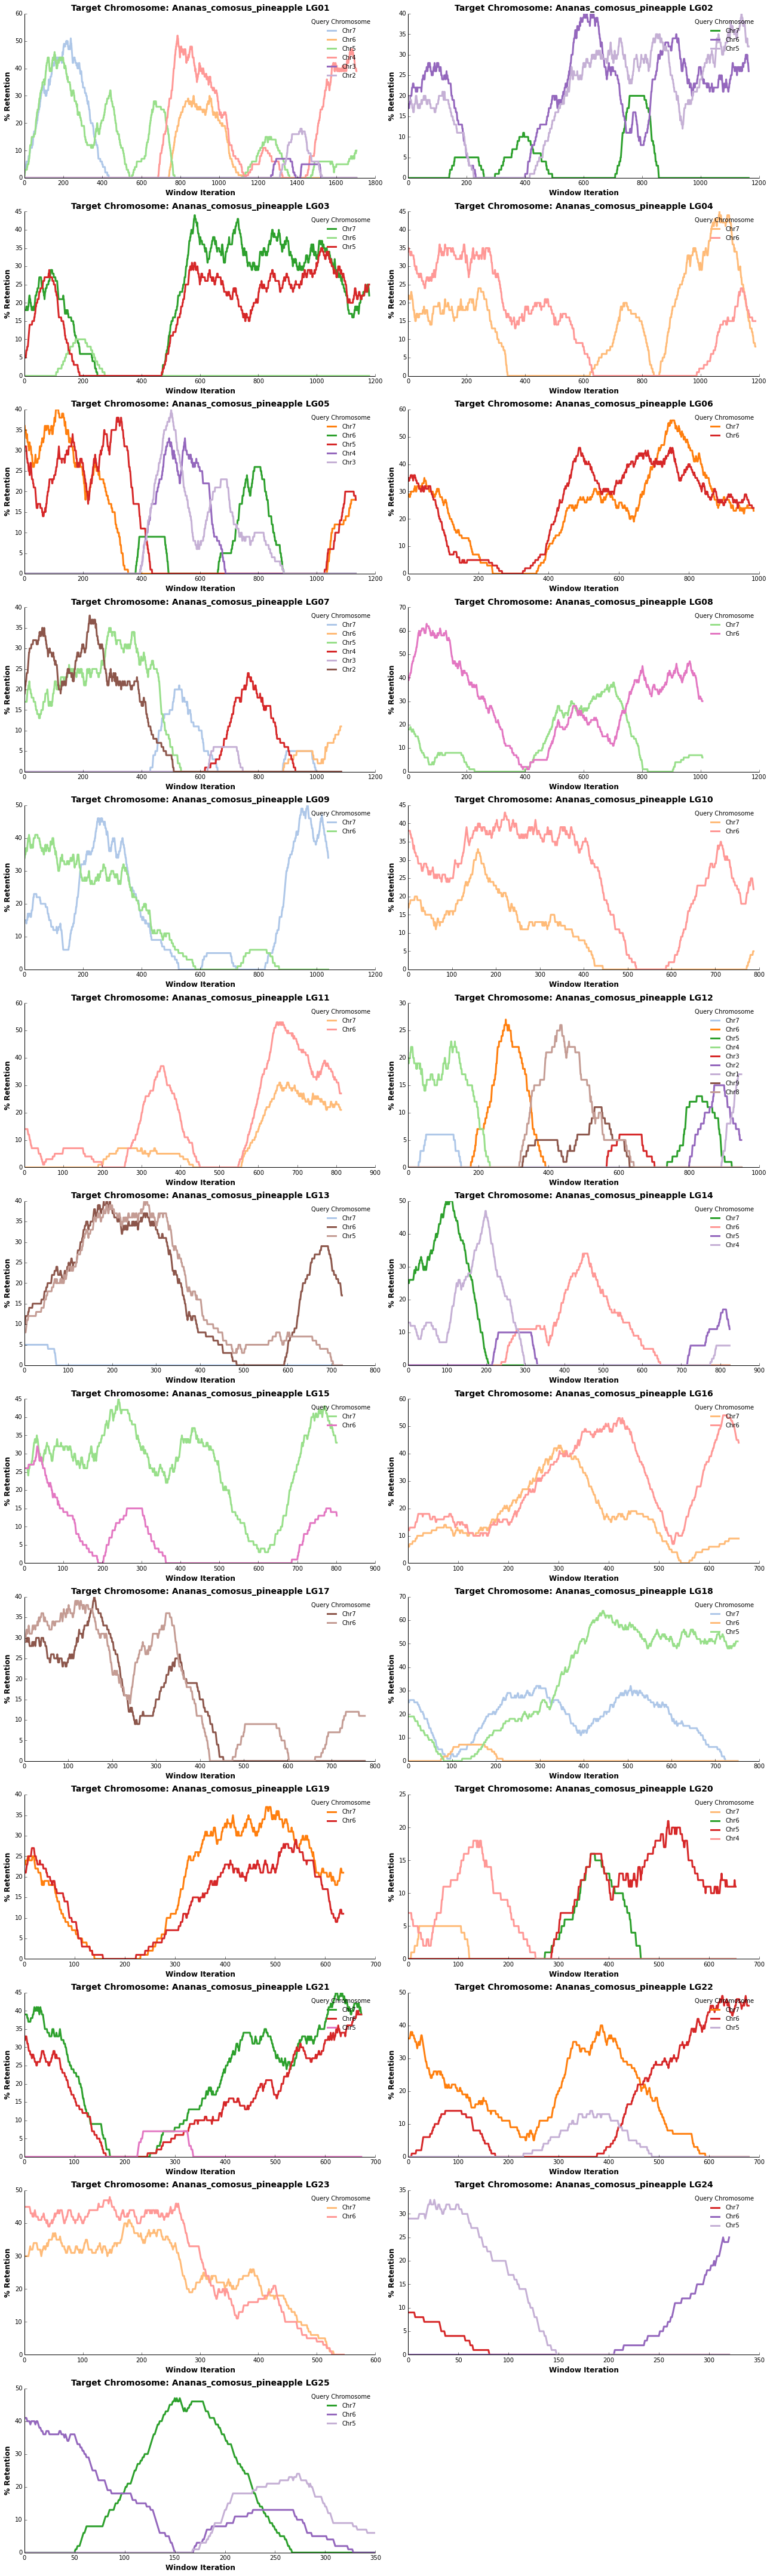

In [18]:
%matplotlib inline


#define figure size, column layout, grid layout
figsize = (18 , 60)
cols = 2
gs = gridspec.GridSpec(len(output_dict) // cols + 1, cols)

# These are the "Tableau 20" colors as RGB  
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)] 

tableau10blind = [(0, 107, 164), (255, 128, 14), (171, 171, 171), (89, 89, 89),
             (95, 158, 209), (200, 82, 0), (137, 137, 137), (163, 200, 236),
             (255, 188, 121), (207, 207, 207)]
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts  
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)
    tableau10blind[i]=(r / 255., g / 255., b / 255.)

fig = plt.figure(figsize=figsize)
subplt_count = -1
ax = []
for tchr in output_dict:
    subplt_count += 1
    print "Plotting target chromosome: "+str(subplt_count)
    count = 0 
    row = (subplt_count // cols)
    col = subplt_count % cols
    ax.append(fig.add_subplot(gs[row, col]))
    
    for qchr in output_dict[tchr]:
        count += 1
        if (max(output_dict[tchr][qchr].itervalues()))>0:
            x = output_dict[tchr][qchr].keys()
            y = output_dict[tchr][qchr].values()    
        else:
            continue
        ax[-1].spines["top"].set_visible(False)
        ax[-1].spines["right"].set_visible(False)
        ax[-1].get_xaxis().tick_bottom()
        ax[-1].get_yaxis().tick_left()
        ax[-1].plot(x, y, color=tableau20[count], lw=3)
        ax[-1].set_title(label='Target Chromosome: '+species_name_filter+" "+ tchr, fontweight='bold', fontsize=14)
        ax[-1].set_xlabel('Window Iteration', fontsize=12, fontweight='bold')
        ax[-1].set_ylabel('% Retention', fontsize=12, fontweight='bold')
        if (max(output_dict[tchr][qchr].itervalues()))>0:
            ax[-1].legend(output_dict[tchr], loc=1, frameon=False, title="Query Chromosome", fontsize=10)
        import operator
fig.tight_layout()


In [19]:
"""Export Processed Fractional Bias Data to JSON File
import json
import csv

with open("myFile.json", "w") as f:
    json.dump(output_dict,f)
    
x = json.loads(output_dict)




f = csv.writer(open("test.csv", "wb+"))

# Write CSV Header, If you dont need that, remove this line
#f.writerow(["pk", "model", "codename", "name", "content_type"])

for x in x:
    f.writerow([x["tchr"], 
                x["tchr"]["qchr"]])
"""

'Export Processed Fractional Bias Data to JSON File\nimport json\nimport csv\n\nwith open("myFile.json", "w") as f:\n    json.dump(output_dict,f)\n    \nx = json.loads(output_dict)\n\n\n\n\nf = csv.writer(open("test.csv", "wb+"))\n\n# Write CSV Header, If you dont need that, remove this line\n#f.writerow(["pk", "model", "codename", "name", "content_type"])\n\nfor x in x:\n    f.writerow([x["tchr"], \n                x["tchr"]["qchr"]])\n'

In [20]:
'''import os
from lightning import Lightning

from numpy import random, asarray, arange
from sklearn import datasets
from scipy.ndimage.filters import gaussian_filter
from seaborn import color_palette


# replace with your own host and credentials, e.g. http://localhost:3000 or http://my-lightning-server.herokuapp.com
host = 'http://lightning-docs.herokuapp.com'
auth = (os.getenv('LIGHTNING_USERNAME'), os.getenv('LIGHTNING_PASSWORD'))

lgn = Lightning(ipython=True, host=host, auth=auth)
lgn.create_session('fractbias');'''




"import os\nfrom lightning import Lightning\n\nfrom numpy import random, asarray, arange\nfrom sklearn import datasets\nfrom scipy.ndimage.filters import gaussian_filter\nfrom seaborn import color_palette\n\n\n# replace with your own host and credentials, e.g. http://localhost:3000 or http://my-lightning-server.herokuapp.com\nhost = 'http://lightning-docs.herokuapp.com'\nauth = (os.getenv('LIGHTNING_USERNAME'), os.getenv('LIGHTNING_PASSWORD'))\n\nlgn = Lightning(ipython=True, host=host, auth=auth)\nlgn.create_session('fractbias');"